In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("hr dataset.csv")
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
data['Gender'] = (data['Gender'] == 'Male').astype(int)

data['OverTime'] = (data['OverTime'] == 'Yes').astype(int)

data['Attrition'] = (data['Attrition']=='Yes').astype(int)

data.drop(['EmployeeCount','EmployeeNumber','StandardHours','Over18'],axis=1,inplace=True)

###### Feature Selection
Some features are unnecessary for this analysis, as they have constant numbers or they represent ID. So they will be dropped from the dataset. Moreover, some categorical variables were converted into binary variables.

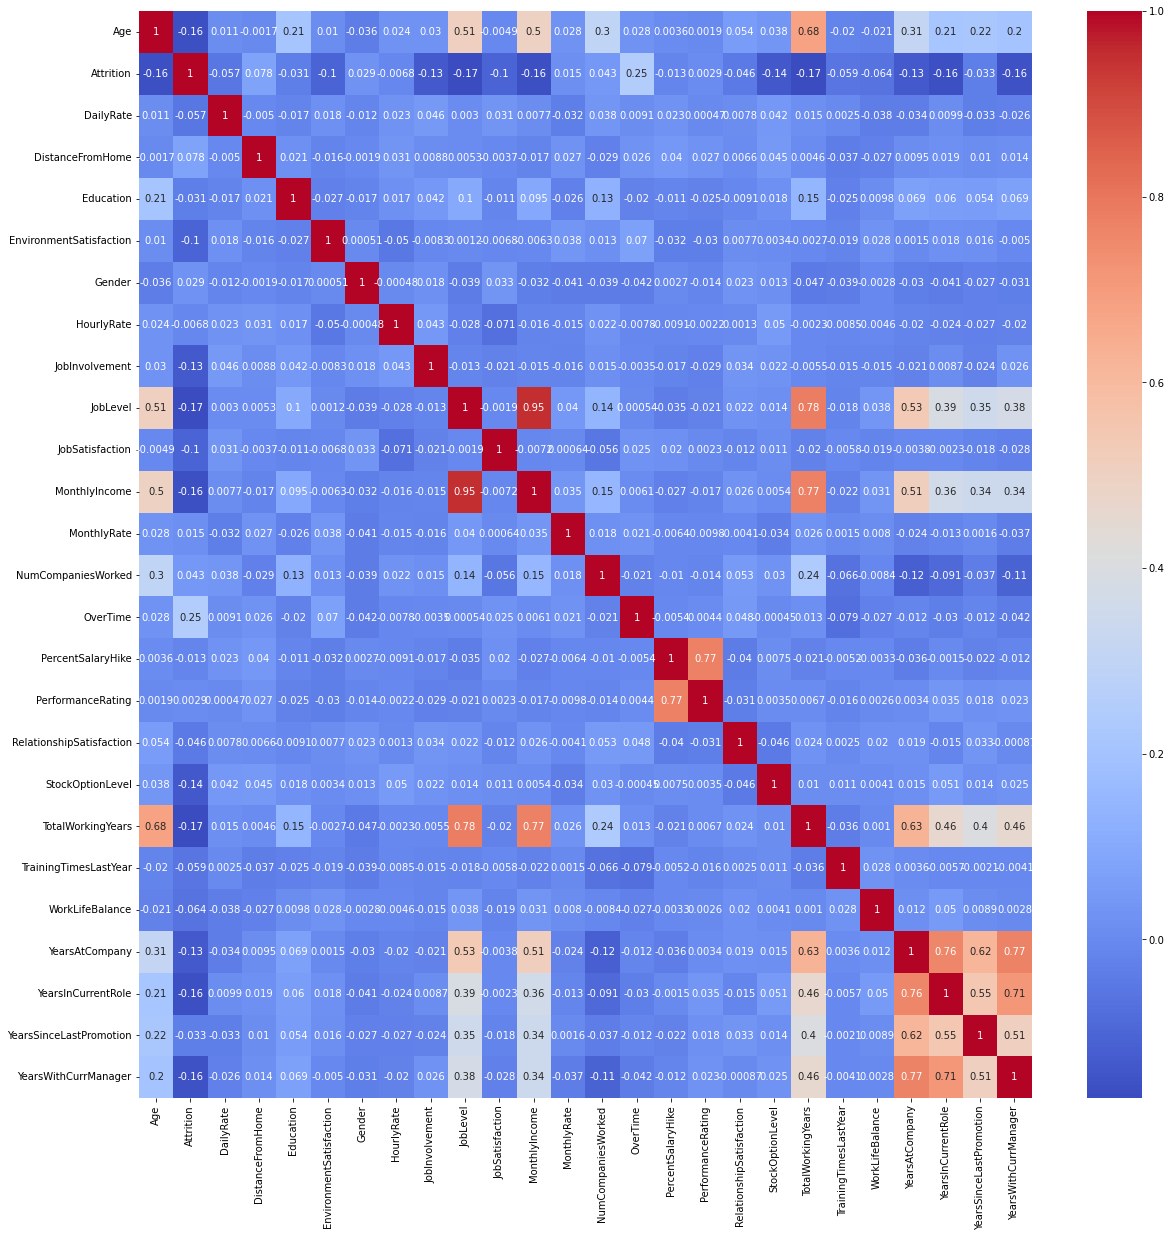

In [4]:
plt.figure(figsize=(20,20))

sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

plt.show()

###### Correlation Matrix
This graph indicates that there is multicollinearity problem: some independent variables have strong correlations with each other (we set benchmark to 0.7). In this case, variables - monthly income, performance rating, years at company, job level and years in current role - will be removed from the dataset in order to avoid overfitting.

###### Important Note
One way to address multicollinearity problem is using PCA method, which it will be used later. However, I will not use the original dataset for PCA method as the goal is to compare PCA effect over models. Let's note that better models can be found with PCA application over original dataset, instead of reduced dataset.

In [5]:
data.drop(['MonthlyIncome','PerformanceRating','YearsAtCompany','JobLevel','YearsInCurrentRole'],axis=1,inplace=True)

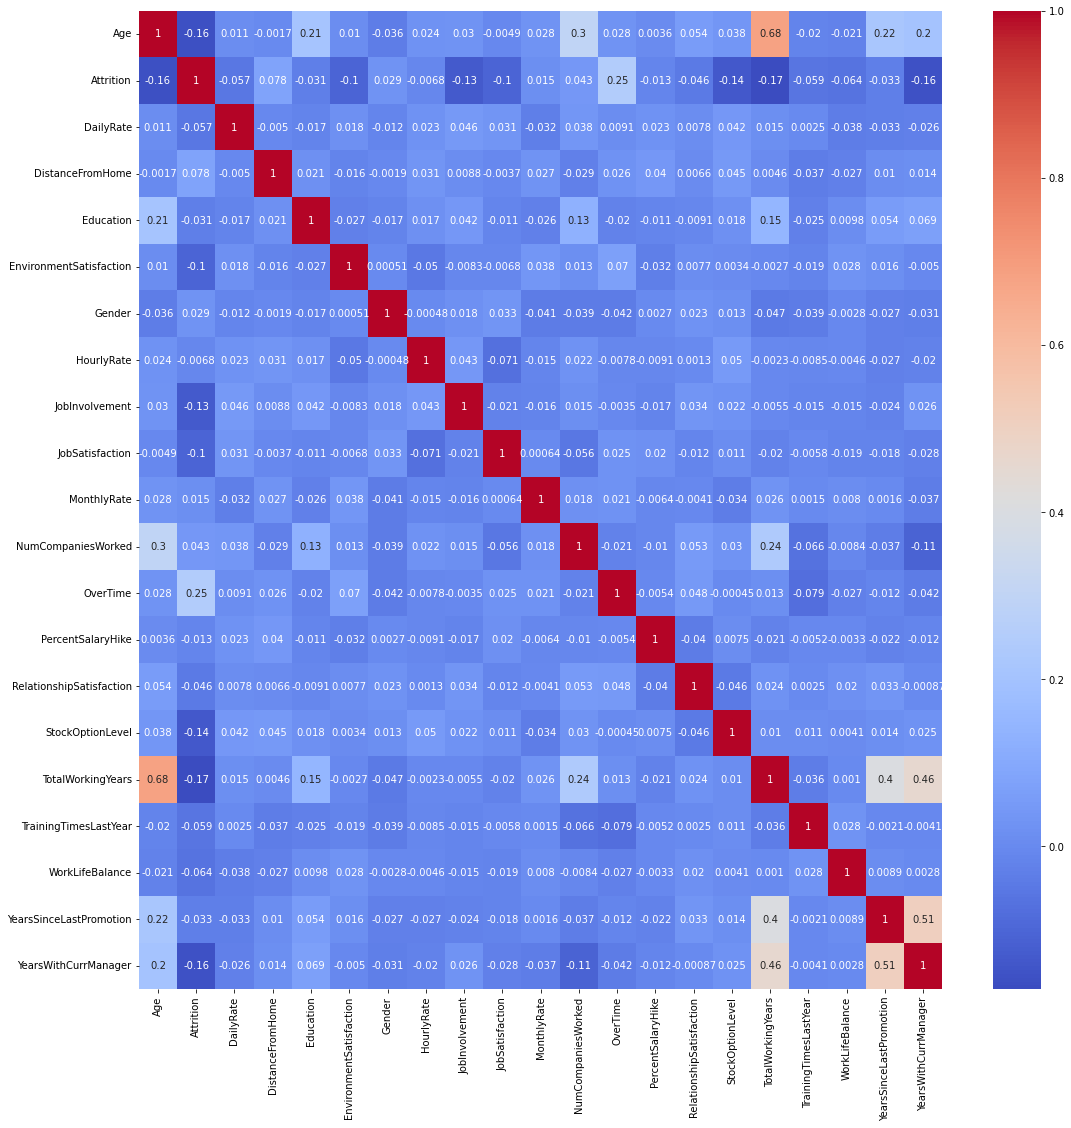

In [6]:
plt.figure(figsize=(18,18))

sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

plt.show()

In [7]:
list=['Department','EducationField','JobRole','JobInvolvement','Education','EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance','RelationshipSatisfaction','MaritalStatus','BusinessTravel']
data = pd.get_dummies(data,columns=list)

###### Getting dummies
Categorical variables was converted to binary variables.

In [8]:
data.head()

,Age,Attrition,DailyRate,DistanceFromHome,Gender,HourlyRate,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,...,RelationshipSatisfaction_1,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,41,1,1102,1,0,94,19479,8,1,11,...,1,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,61,24907,1,0,23,...,0,0,0,1,0,1,0,0,1,0
2,37,1,1373,2,1,92,2396,6,1,15,...,0,1,0,0,0,0,1,0,0,1
3,33,0,1392,3,0,56,23159,1,1,11,...,0,0,1,0,0,1,0,0,1,0
4,27,0,591,2,1,40,16632,9,0,12,...,0,0,0,1,0,1,0,0,0,1


### Modelling

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV

In [45]:
scaler = StandardScaler()

In [46]:
X = data.drop('Attrition',axis=1)
y = data['Attrition']

In [47]:
X_scaled = scaler.fit_transform(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,train_size=0.2,random_state=41)

In [49]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

#### Hyperparameter Optimization

In [15]:
%%time

param_grid = {
    'penalty': ['l1', 'l2'],        
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept' : [True,False],
    'max_iter' :[50,100,200,300,500]
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Parameters: {'C': 0.1, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2'}
Best Score: 0.8434248977206312
CPU times: total: 9.61 s
Wall time: 3.2 s


In [16]:
%%time
param_grid = {
    'n_estimators': [10,50,100,200,250,300],
    'max_depth': [None, 10, 20, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}
Best Score: 0.8367036820572764
CPU times: total: 49.7 s
Wall time: 53.4 s


In [17]:
%%time
param_grid = {
    'n_estimators': [50,100,150,200,300],
    'learning_rate': [0.01, 0.1, 0.25, 0.5],
    'max_depth': [None,3,5,7,10],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print('Best Parameters:\n', grid_search.best_params_)
print('Best Score:\n', grid_search.best_score_)

Best Parameters:
 {'learning_rate': 0.25, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}
Best Score:
 0.8503798947983634
CPU times: total: 3min 57s
Wall time: 4min 26s


#### Prediction

In [50]:
lr = LogisticRegression(C=0.1, max_iter=50, fit_intercept= True, penalty ='l2', random_state=45)
rf = RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=50, random_state=45)
gb = GradientBoostingClassifier(learning_rate=0.25, max_depth=3, max_features='log2',n_estimators=100,random_state=45)

In [51]:
models = [lr, rf, gb]
model_names = ['Logistic Regression','Random Forest','Gradient Boosting']
predictions = []

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    pred_y=model.predict(X_test)
    predictions.append(pred_y)
    a = accuracy_score(y_test, pred_y)
    print(f'{name} Accuracy score: {round(a,4)}\n')

Logistic Regression Accuracy score: 0.8435

Random Forest Accuracy score: 0.8452

Gradient Boosting Accuracy score: 0.8333



###### Model Comparison
Based on accuracy scores, Gradient Boosting is performing better than others. However, it is not enough, other metrics also should be considered.

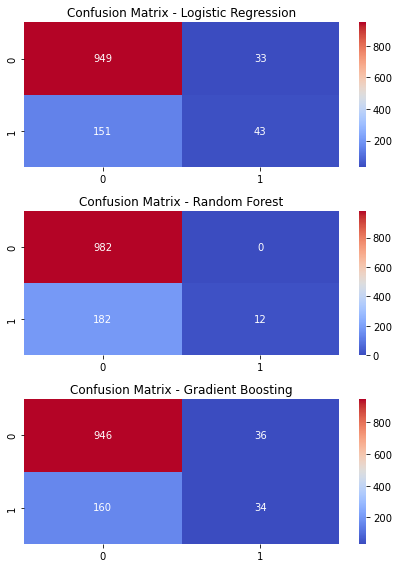

In [52]:
cm_lr = confusion_matrix(y_test,predictions[0])
cm_rf = confusion_matrix(y_test,predictions[1])
cm_gb = confusion_matrix(y_test,predictions[2])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))

sns.heatmap(cm_lr, cmap='coolwarm', annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression')

sns.heatmap(cm_rf, cmap='coolwarm', annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Confusion Matrix - Random Forest')

sns.heatmap(cm_gb, cmap='coolwarm', annot=True, fmt='d', ax=axes[2])
axes[2].set_title('Confusion Matrix - Gradient Boosting')

plt.tight_layout()
plt.show()

In [53]:
column_n = X.shape[1] # taking the number of features

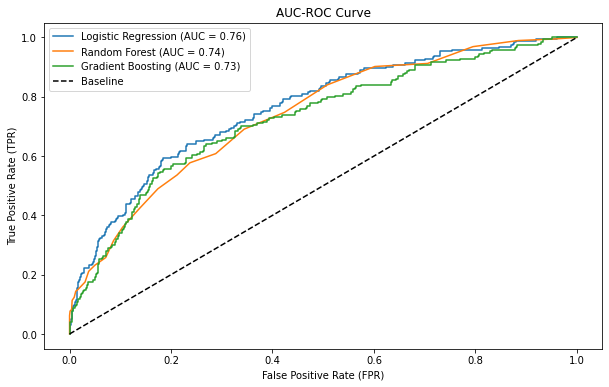

In [54]:
plt.figure(figsize=(10, 6))
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
accuracy = []

for model, name in zip(models, model_names):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    
    # AUC Score
    auc = roc_auc_score(y_test, y_prob)
    
    # Plotting AUC-ROC Curves
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    
    # Other Metrics
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    acc = accuracy_score(y_test, y_pred)

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy.append(acc)

    
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('AUC-ROC Curve')
plt.legend()
plt.show()

In [55]:
metrics_df = pd.DataFrame({
    'Model': model_names,
    'AUC': auc_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Accuracy': accuracy
})

print(f"Model Evaluation Metrics with {column_n} features:\n")
print(metrics_df)

Model Evaluation Metrics with 63 features:

                 Model       AUC  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression  0.762698   0.565789  0.221649  0.318519  0.843537
1        Random Forest  0.740182   1.000000  0.061856  0.116505  0.845238
2    Gradient Boosting  0.728290   0.485714  0.175258  0.257576  0.833333


###### Comparison of Models
According to the metrics above, Logistic Regression (LR) has better values for all the metrics. Random Forest (RF) is underperforming in case of every metrics, except for precision score, however, that's not enough, it is the indication of overfitting. Gradient Boosting (GB) has close values to LR, however less than LR.

In this analysis, F1 Score is the most important indicator as it balances Precision and Recall values respective to their weights. We want to have better overall model, with highest possible Recall scores.

Overall, LR is better than all other models.

#### Principal Component Analysis

In [56]:
pca = PCA()

pipeline = make_pipeline(scaler,pca)

In [57]:
X_pca = pipeline.fit_transform(X)

In [58]:
explained_variance=pca.explained_variance_ratio_

features = range(pca.n_components_)

cumsum = explained_variance.cumsum()

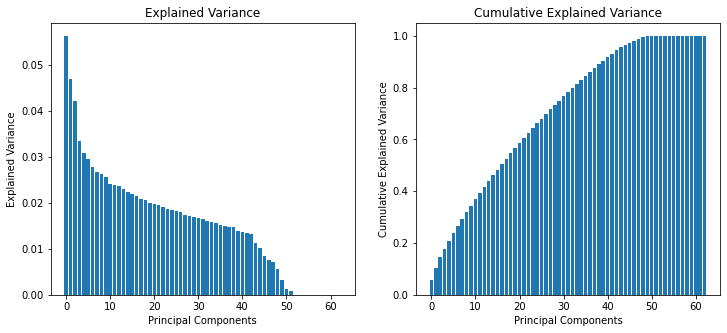

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].bar(features, explained_variance)
axes[0].set_title('Explained Variance')
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance')

axes[1].bar(features, cumsum)
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')

plt.show()

###### Graph Interpration
First graph clearly shows that TOP3 features explains significantly more variances than the rest. However, these 3 features only explains around 17% of all variance of target variable, which is not enough. Therefore, we will take 42 as the number of components, because we don't want to reduce dimensionality too much as it hurts model accuracy. We need balanced model with slightly less features.

Why 42? Based on first graph, there is a sharp decline in explained variance after component 42. At the same time, the second graph shows that those 42 features already explain around 90% of all variance. That's why we decided that 42 is optimal number of components.

#### Feature Reduction

In [60]:
pca_new = PCA(n_components=42)
pipeline_new = make_pipeline(scaler,pca_new)
X_pca_reduced = pipeline_new.fit_transform(X)

In [61]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=41)

In [62]:
column_n_pca = X_pca_reduced.shape[1]

In [63]:
for model, name in zip(models, model_names):
    model.fit(X_train_pca, y_train_pca)
    y_pred = model.predict(X_test_pca)
    
    ac = accuracy_score(y_test_pca, y_pred)
    print(f'Accuracy score of {name} model:', round(ac,4))

Accuracy score of Logistic Regression model: 0.898
Accuracy score of Random Forest model: 0.8776
Accuracy score of Gradient Boosting model: 0.898


###### Model Comparison
After the algorithm, we can see that there is significant increases in the predictive power of our models. Let's explore more!

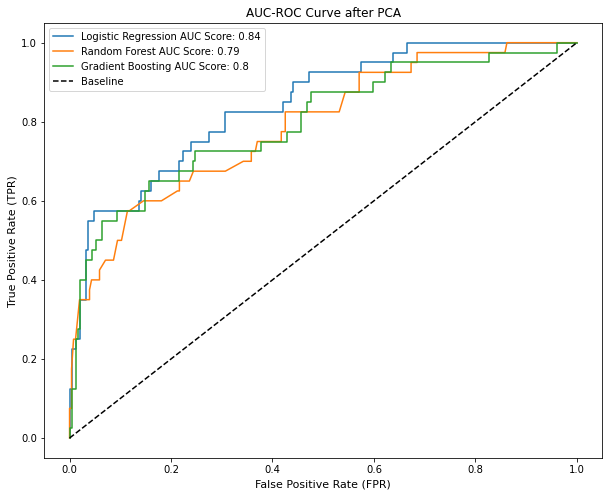

In [64]:
f1_pca = []
accuracy_pca = []
precision_pca = []
recall_pca = []
auc_pca = []

plt.figure(figsize=(10,8))

for model, name in zip(models, model_names):
    model.fit(X_train_pca,y_train_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_pca, y_prob, pos_label=1)
    
    # AUC Score
    auc = roc_auc_score(y_test_pca, y_prob)
    
    # Plotting AUC-ROC Curves
    plt.plot(fpr, tpr, label=f'{name} AUC Score: {round(auc,2)}')
    
    # Other Metrics
    y_pred = model.predict(X_test_pca)
    
    f1 = f1_score(y_test_pca,y_pred, pos_label=1)
    rec = recall_score(y_test_pca,y_pred, pos_label=1)
    prec = precision_score(y_test_pca,y_pred, pos_label=1)
    acc = accuracy_score(y_test_pca,y_pred)
    
    auc_pca.append(auc)
    precision_pca.append(prec)
    recall_pca.append(rec)
    f1_pca.append(f1)
    accuracy_pca.append(acc)
    


plt.plot([0,1],[0,1],'k--', label='Baseline')

plt.xlabel('False Positive Rate (FPR)',fontsize=11)
plt.ylabel('True Positive Rate (TPR)',fontsize=11)
plt.title('AUC-ROC Curve after PCA')
plt.legend()
plt.show()

###### Graph Interpretation
AUC Scores are almost the same. An AUC of 0.78 implies that the model has an 78% chance of correctly ranking a randomly chosen positive instance higher than a randomly chosen negative instance.

In [65]:
metrics_pca = pd.DataFrame({
    'Model': model_names,
    'AUC': auc_pca,
    'Precision': precision_pca,
    'Recall': recall_pca,
    'F1 Score': f1_pca,
    'Accuracy': accuracy_pca
})

print(f"Model Evaluation Metrics with {column_n_pca} features:\n")
print(metrics_pca)

Model Evaluation Metrics with 42 features:

                 Model       AUC  Precision  Recall  F1 Score  Accuracy
0  Logistic Regression  0.843602   0.678571   0.475  0.558824  0.897959
1        Random Forest  0.791339   0.833333   0.125  0.217391  0.877551
2    Gradient Boosting  0.799016   0.692308   0.450  0.545455  0.897959


###### Model Comparison after PCA algorithm
There is significant improvement in the performance of all models! However, RF tends to overfit the data again, therefore we will ignore it and will focus on LR and GB.

With the reduction of features, LR gained significant precision, recall scores and because of that F1 score significantly improved. AUC score increased slightly. Accuracy score and F1-score increased from 0.84 to 0.9 and from 0.32 to 0.56, respectively.

On the other hand, GB gained predictive power too. All metrics increased significantly. Accuracy score increased to 0.9!

Overall, LR is better than GB.

In [66]:
print(metrics_df)

                 Model       AUC  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression  0.762698   0.565789  0.221649  0.318519  0.843537
1        Random Forest  0.740182   1.000000  0.061856  0.116505  0.845238
2    Gradient Boosting  0.728290   0.485714  0.175258  0.257576  0.833333


In [67]:
print(f"Metrics with {column_n} features:\n")
print(metrics_df[0:1],'\n\n')

print(f"Metrics with {column_n_pca} features:\n")
print(metrics_pca[0:1])

Metrics with 63 features:

                 Model       AUC  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression  0.762698   0.565789  0.221649  0.318519  0.843537 


Metrics with 42 features:

                 Model       AUC  Precision  Recall  F1 Score  Accuracy
0  Logistic Regression  0.843602   0.678571   0.475  0.558824  0.897959


###### Methodology Comparison
From the above tables, we can observe that PCA algorithm has significant impact over the predictive power of Logistic Regression. Therefore, it is better to reduce dimensionality to reduce noise and increase generalization.